## LGT1 Unit 3 day 14 exercise

In today's exercise we look at the explicit chiral symmetry breaking in domain wall fermions due to the finite extent of the fifth dimension. We will generate a small quenched configuration, calculate the divergence of the vector current, the divergence of the axial current, and calculate the residual mass with a varying extent in the fifth dimension to see how increasing $L_s$ decreases the explicit chiral symmetry breaking.  

In [34]:
import gpt as g
import numpy as np
import matplotlib.pyplot as plt

The following cell generates a single quenched configuration. 

In [35]:
def heatbath_quenched_config(L,Lt,beta):
    #create 1 config
    L = [L,L,L,Lt]
    grid = g.grid(L, g.single)
    grid_eo = g.grid(L, g.single, g.redblack)
    
    rng = g.random("test", "vectorized_ranlux24_24_64")
    U = g.qcd.gauge.unit(grid)
    Nd = len(U)
    
    # red/black mask
    mask_rb = g.complex(grid_eo)
    mask_rb[:] = 1
    # full mask
    mask = g.complex(grid)
    
    # simple plaquette action
    def staple(U, mu):
        st = g.lattice(U[0])
        st[:] = 0
        Nd = len(U)
        for nu in range(Nd):
            if mu != nu:
                st += g.qcd.gauge.staple(U, mu, nu) / U[0].otype.Nc
        return st
    
    g.default.push_verbose("su2_heat_bath", False)
    markov = g.algorithms.markov.su2_heat_bath(rng)
    U = g.qcd.gauge.unit(grid)
    plaquette_heatbath = []
    for it in range(150):
        plaq = g.qcd.gauge.plaquette(U)
        plaquette_heatbath.append(plaq)
        if it % 50 == 0:
            g.message(f"SU(2)-subgroup heatbath {it} has P = {plaq}")
        for cb in [g.even, g.odd]:
            mask[:] = 0
            mask_rb.checkerboard(cb)
            g.set_checkerboard(mask, mask_rb)
    
            for mu in range(Nd):
                st = g.eval(beta * staple(U, mu))
                markov(U[mu], st, mask)

    return U

In [36]:
#The Ls = 24 case might take a long time, so feel free to make the test configuration smaller. 
U = heatbath_quenched_config(8,8,5.5)
grid = g.grid([8,8,8,8],g.double)

GPT :    1979.942515 s : Initializing gpt.random(test,vectorized_ranlux24_24_64) took 0.000102758 s
GPT :    1979.999599 s : SU(2)-subgroup heatbath 0 has P = 1.0
GPT :    1987.224906 s : SU(2)-subgroup heatbath 50 has P = 0.5029050509134928
GPT :    1994.357431 s : SU(2)-subgroup heatbath 100 has P = 0.4927652147081163


Next we define the fermion parameters, and the domain wall fermion operator. We start with $L_s = 8$. To change the extent of the fifth dimension, change it here in the dwf_params

In [37]:
#If you change the config size, be sure to change it here too.
grid = g.grid([8,8,8,8],g.double)

#This is where you change Ls
dwf_params = {
    "mass":0.01,
    "M5":1.8,
    "b":1.0,
    "c":0.0,
    "Ls":8,
    "boundary_phases":[1.0,1.0,1.0,-1.0]
}

qm = g.qcd.fermion.mobius(U,dwf_params)

We are interested in looking at the Ward identities for the axial and vector current, so we first calculate the 5D propagator.  

In the cell below we have code that defines the fermion operator in 5D, defines all that we need to invert it with conjugate gradient method, and then it does the inversion to give us the 5D propagator. 

In [38]:
#conjugate gradient things to invert the 5D operator
cg_iter = 500 #change this if you are using Ls = 24 or higher
pc = g.qcd.fermion.preconditioner
inv = g.algorithms.inverter
cg = inv.cg({"eps":1e-6,"maxiter":cg_iter}) #cg to be used for 5D operator inversion
slv_5d = inv.preconditioned(pc.eo1_ne(),cg)

Q_5d = qm.bulk_propagator(slv_5d) #This for 5D propagator

src = g.mspincolor(U[0].grid) #we create a source at point [1,0,0,0] 
g.create.point(src,[1,0,0,0]);

In [39]:
pbulk = g(Q_5d * src)

GPT :    2039.051775 s : cg: converged in 216 iterations
GPT :    2039.568641 s : cg: converged in 231 iterations
GPT :    2039.840732 s : cg: converged in 238 iterations
GPT :    2040.101099 s : cg: converged in 232 iterations
GPT :    2040.445571 s : cg: converged in 235 iterations
GPT :    2040.715605 s : cg: converged in 224 iterations
GPT :    2040.962724 s : cg: converged in 215 iterations
GPT :    2041.302695 s : cg: converged in 209 iterations
GPT :    2041.578538 s : cg: converged in 219 iterations
GPT :    2041.870643 s : cg: converged in 216 iterations
GPT :    2042.207981 s : cg: converged in 217 iterations
GPT :    2042.470184 s : cg: converged in 215 iterations


Below we convert the 5D propagator to the 4D propagator. We use this to evaluate the correlator of the pseudoscalar density

In [42]:
p4d = g.mspincolor(U[0].grid)
p4d @= qm.bulk_propagator_to_propagator * pbulk

Below is a cell to calculate the conserved vector current. We print out the divergence with the contact term, then we set it to zero and look at it without the contact term from the Ward identity. 

In [43]:
j = qm.J5q(pbulk)
J5q = g.slice(g.trace(j*g.adj(j)),3)

div = g.mspin(U[0].grid)
div[:] = 0

for mu in range(4):
    tmp = qm.conserved_vector_current(pbulk,src,pbulk,src,mu)
    tmp-=g.cshift(tmp,mu,-1)
    div+=g.color_trace(tmp)

div = g(g.trace(g.adj(div)*div))

g.message("divergence contact term",div[1,0,0,0].real)
div[1,0,0,0] = 0
eps = g.sum(div).real
g.message(f"divergence = {eps} without contact term")
    

GPT :    2152.733892 s : divergence contact term 4.279424579457791e-13
GPT :    2152.753240 s : divergence = 5.223988881313804e-15 without contact term


Now we move on to the axial Ward identity, with the goal of calculating the residual mass. We start by defining the correlator of the axial current which we call AP, and the physical mass term proportional to $J_5^a$. $J_{5q}$ is defined above in the vector current function

In [44]:
AP = g.slice(g.trace(qm.conserved_axial_current(pbulk,src,pbulk,src,3)*g.gamma[5]),3) #expectation value of axial current
PP = g.slice(g.trace(p4d*g.adj(p4d)),3) #J_5

EXERCISE: From the axial Ward identity, construct the left hand side, the divergence of the axial current term using the above defined AP, and construct the effective mass term using the above defined PP and J5q. Once again here is the Ward identity

$$
\Delta_{\mu}\left\langle A^a_{\mu}O(y_1,y_2,...) \right\rangle = 2m \left\langle J^a_5(x)O(y_1,y_2,...) \right\rangle + 2 \left\langle J^a_{5q}(x) O(y_1,y_2,...) \right\rangle + i \left\langle \delta^a_A O(y_1,y_2,...) \right\rangle
$$

Where in this case we drop the contact term, and the operator we are using as $O$ is the pseudoscalar density $J_5^a$. We already have all three of these correlation functions defined above, all that needs to be done is  them together in this form. 

In [46]:
#change Nt based on the size of the config you have
Nt = 8
t = np.arange(0,Nt,1)
res_list = []
for t in range(Nt):
    
    # Use a discrete derivative on correlator AP to construct the lhs of the Ward identity
    # construct the effective mass term of the rhs of the Ward identity
    dAP_t = #divergence of axial current
    mass_term = #effectice mass, rhs of Ward identity
    
    eps = abs(dAP_t - mass_term)/abs(dAP_t + mass_term)
    
    mres = J5q[t]/PP[t] 

    if t!=0:
        g.message(f"axial vector current divergence residuum at t={t}: {eps}")
        g.message(f"Axial vector mass term: t={t}: {mass_term}")
        g.message(f"residual mass: t={t}: {mres}")
        res_list.append(mres.real)

GPT :    2168.982047 s : axial vector current divergence residuum at t=1: 0.3040138180623248
GPT :    2168.982663 s : Axial vector mass term: t=1: (0.07795841962099076-2.1296561285299998e-11j)
GPT :    2168.983586 s : residual mass: t=1: (0.07012633428388171-2.947689682046218e-12j)
GPT :    2168.984047 s : axial vector current divergence residuum at t=2: 0.19765746113755076
GPT :    2168.984646 s : Axial vector mass term: t=2: (0.03266248315572739+2.6230048948833184e-13j)
GPT :    2168.985039 s : residual mass: t=2: (0.13207469676968428-1.6040351489398653e-11j)
GPT :    2168.985563 s : axial vector current divergence residuum at t=3: 0.19452719740819155
GPT :    2168.986062 s : Axial vector mass term: t=3: (0.014746914878487588+9.223520189803603e-13j)
GPT :    2168.986528 s : residual mass: t=3: (0.13492546659996546+9.66184771585767e-12j)
GPT :    2168.986972 s : axial vector current divergence residuum at t=4: 0.19337297230310455
GPT :    2168.987313 s : Axial vector mass term: t=4: (

EXERCISE: plot the residual mass over all time slices. 

Text(0, 0.5, 'residual mass')

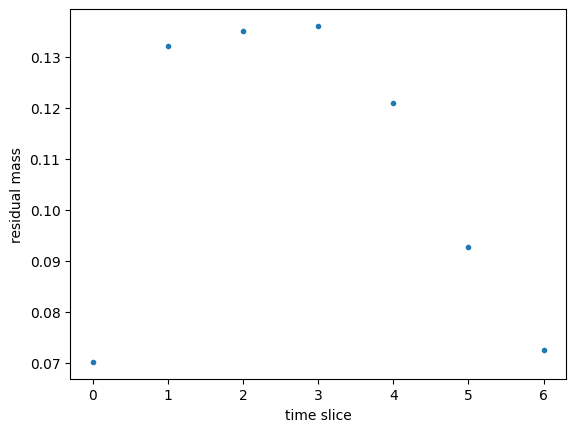

In [49]:
#plot the residual mass 

EXERCISE: Repeat the above exercise for a higher value of Ls. Ideally this just entails running the entire notebook again for a different value of $L_s$. 